In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from pathlib import Path

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.teamgamelogs import TeamGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from nba_api.stats.endpoints.leaguedashteamptshot import LeagueDashTeamPtShot

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.teamgamelogs import TeamGameLogs

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [10]:
game_logs = PlayerGameLogs(season_nullable='2021-22').get_data_frames()[0]

In [11]:
player = game_logs.loc[game_logs.PLAYER_NAME == 'Stephen Curry']

In [12]:
game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

In [13]:
player.var().FG3_PCT

0.022776646577380946

In [14]:
player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2021-22').get_data_frames()[0]

In [15]:
player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

In [16]:
top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

In [17]:
top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

In [18]:
top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [19]:
variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

In [20]:
top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

In [21]:
deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

In [22]:
top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [23]:
#top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

In [83]:
plt.style.use('fivethirtyeight')

In [84]:

zoom = 0.45
team_root_dir = '../../team_logos_id/'
player_root_dir = 'player_imgs/'

def get_player_img(player_id, zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

Text(0.5, 1.0, 'Consistency of 3pt percentage of best shooters\n(lower variance = more consistency)')

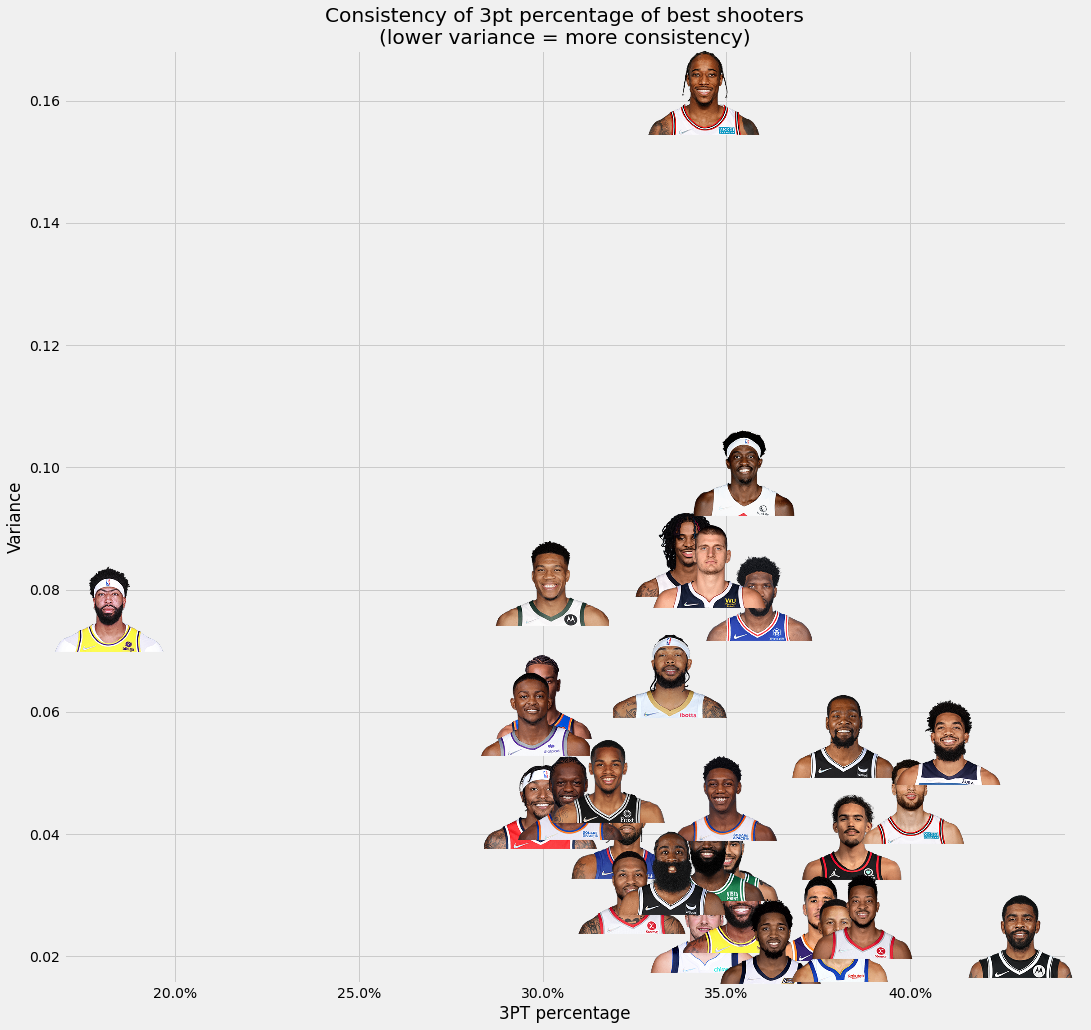

In [39]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.FG3_PCT, y=top_shooters.FG3_PCT_VARIANCE, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_VARIANCE), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Variance")

ax.set_title("Consistency of 3pt percentage of best shooters\n(lower variance = more consistency)")

Text(0.5, 1.0, 'Consistency of 3pt percentage of best shooters\n(lower deviation = more consistency)')

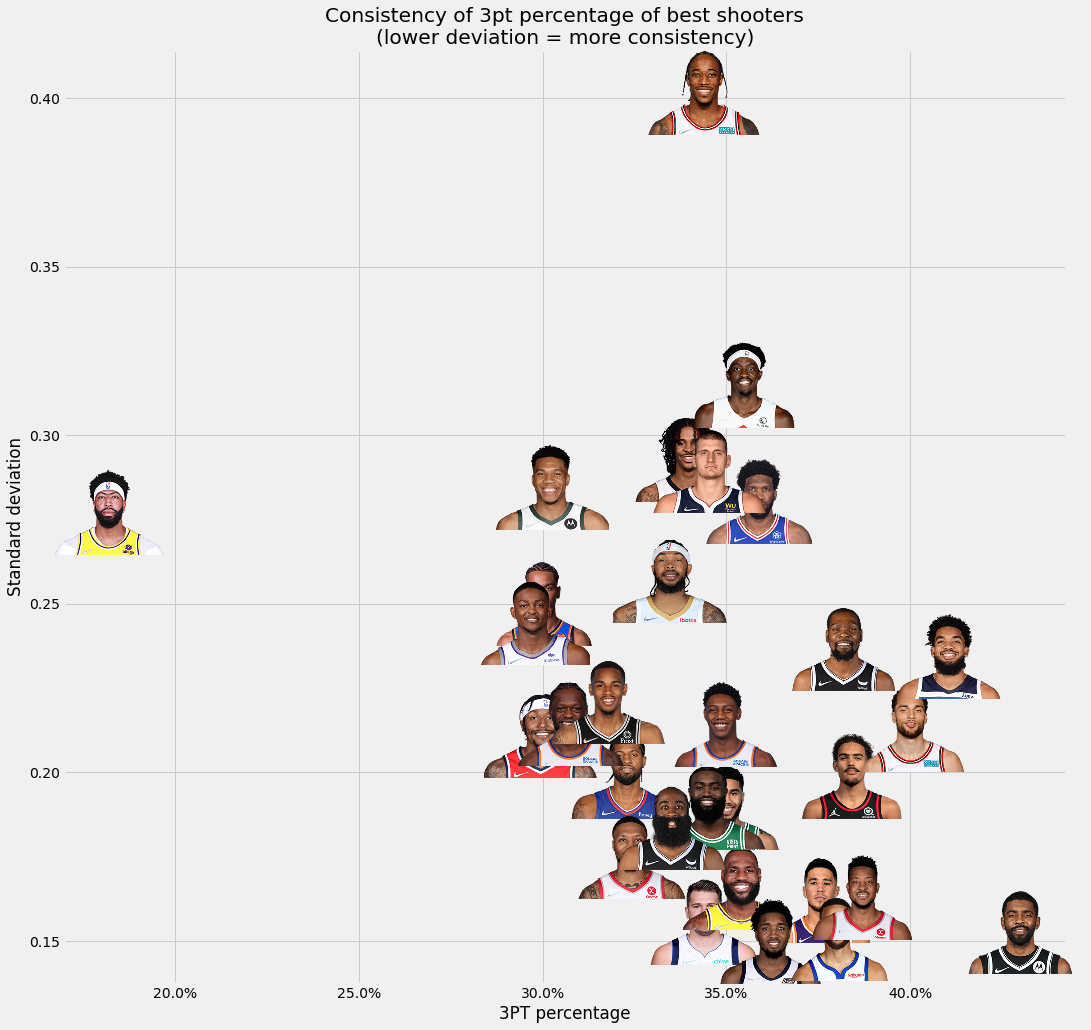

In [40]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.FG3_PCT, y=top_shooters.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of 3pt percentage of best shooters\n(lower deviation = more consistency)")

Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2021-22\n(lower deviation = more consistency)')

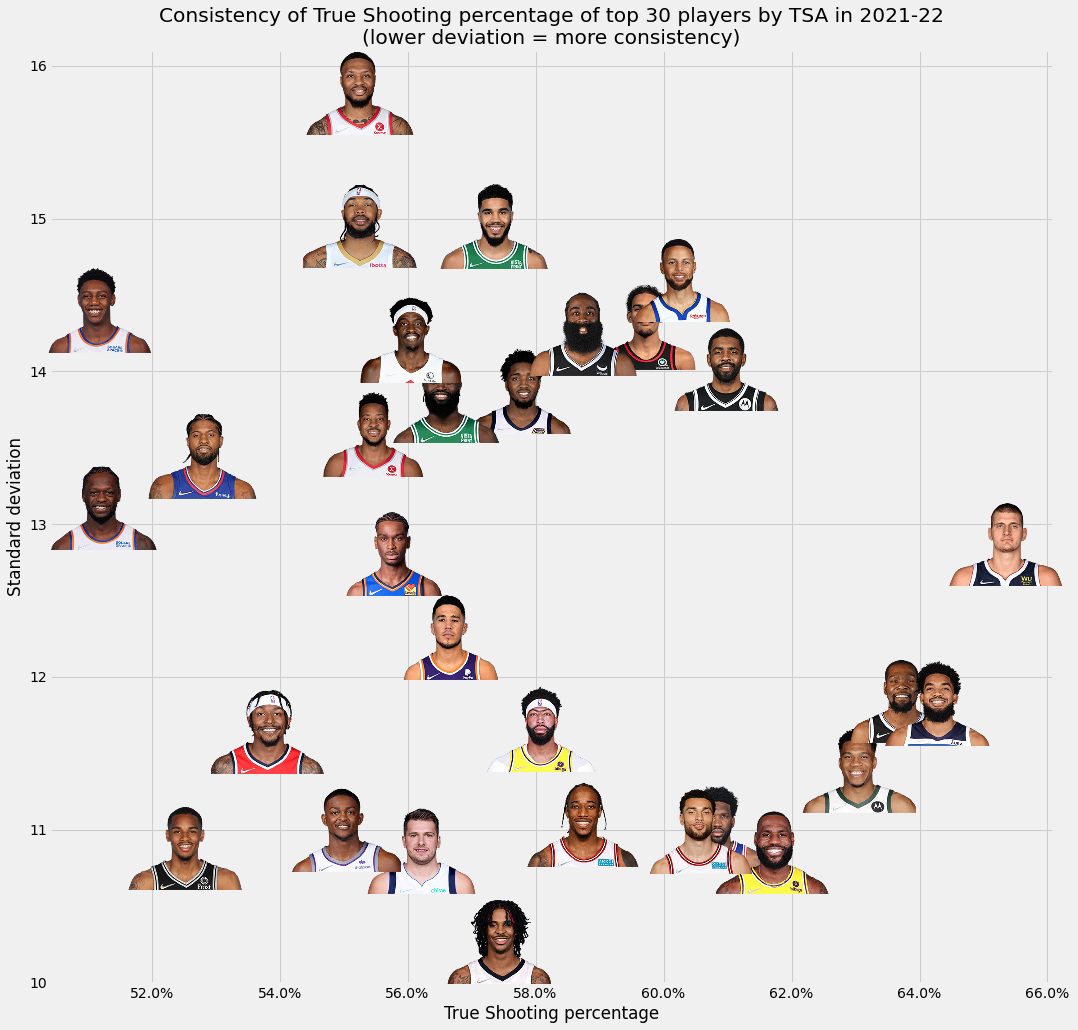

In [26]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of True Shooting percentage of top 30 players by TSA in 2021-22\n(lower deviation = more consistency)")

### Removing variance

#### Loading team game logs

In [29]:
team_logs = TeamGameLogs(season_nullable='2021-22').get_data_frames()[0]

In [27]:
mills_data = game_logs.loc[game_logs.PLAYER_NAME == 'Patty Mills']

In [43]:
mills_mean = mills_data.FG3M.sum() / mills_data.FG3A.sum()

In [56]:

for player_name in top_shooters.PLAYER_NAME.unique():
    player_data = game_logs.loc[game_logs.PLAYER_NAME == player_name]
    losses = 0
    print(player_name)
    for i in range(len(player_data)):
        item = player_data.iloc[i]
        single_game = team_logs.loc[team_logs.GAME_ID == item.GAME_ID]
        single_data = single_game.iloc[0]
        own_team = single_game.loc[single_game.TEAM_ID == item.TEAM_ID].iloc[0]
        other_team = single_game.loc[single_game.TEAM_ID != item.TEAM_ID].iloc[0]
        adjusted_fg3m = round(item.FG3A * mills_mean)
        adjusted_score = own_team.PTS - (item.FG3M * 3) + (adjusted_fg3m * 3)
        if adjusted_score < other_team.PTS and own_team.PTS > other_team.PTS:
            losses += 1
        print(f"\tFG3M/FG3A: {item.FG3M}/{item.FG3A}, result: {own_team.PTS}-{other_team.PTS}, adjusted FG3M/FG3A: {adjusted_fg3m}/{item.FG3A}, adjusted result: {adjusted_score} - {other_team.PTS}")
    print(f"\tTotal losses added with mean FG3%: {losses}")

Stephen Curry
	FG3M/FG3A: 5/16, result: 116-107, adjusted FG3M/FG3A: 7.0/16, adjusted result: 122.0 - 107
	FG3M/FG3A: 8/14, result: 113-104, adjusted FG3M/FG3A: 6.0/14, adjusted result: 107.0 - 104
	FG3M/FG3A: 4/12, result: 113-98, adjusted FG3M/FG3A: 5.0/12, adjusted result: 116.0 - 98
	FG3M/FG3A: 5/14, result: 111-107, adjusted FG3M/FG3A: 6.0/14, adjusted result: 114.0 - 107
	FG3M/FG3A: 5/14, result: 105-96, adjusted FG3M/FG3A: 6.0/14, adjusted result: 108.0 - 96
	FG3M/FG3A: 5/15, result: 102-100, adjusted FG3M/FG3A: 7.0/15, adjusted result: 108.0 - 100
	FG3M/FG3A: 3/14, result: 93-102, adjusted FG3M/FG3A: 6.0/14, adjusted result: 102.0 - 102
	FG3M/FG3A: 6/17, result: 104-94, adjusted FG3M/FG3A: 7.0/17, adjusted result: 107.0 - 94
	FG3M/FG3A: 7/13, result: 126-95, adjusted FG3M/FG3A: 6.0/13, adjusted result: 123.0 - 95
	FG3M/FG3A: 5/17, result: 107-112, adjusted FG3M/FG3A: 7.0/17, adjusted result: 113.0 - 112
	FG3M/FG3A: 6/11, result: 118-96, adjusted FG3M/FG3A: 5.0/11, adjusted resu

	FG3M/FG3A: 4/12, result: 103-109, adjusted FG3M/FG3A: 5.0/12, adjusted result: 106.0 - 109
	FG3M/FG3A: 3/11, result: 126-128, adjusted FG3M/FG3A: 5.0/11, adjusted result: 132.0 - 128
	FG3M/FG3A: 2/7, result: 124-103, adjusted FG3M/FG3A: 3.0/7, adjusted result: 127.0 - 103
	FG3M/FG3A: 4/9, result: 123-98, adjusted FG3M/FG3A: 4.0/9, adjusted result: 123.0 - 98
	FG3M/FG3A: 5/10, result: 118-96, adjusted FG3M/FG3A: 4.0/10, adjusted result: 115.0 - 96
	FG3M/FG3A: 5/12, result: 136-104, adjusted FG3M/FG3A: 5.0/12, adjusted result: 136.0 - 104
	FG3M/FG3A: 4/8, result: 109-108, adjusted FG3M/FG3A: 4.0/8, adjusted result: 109.0 - 108
	FG3M/FG3A: 6/14, result: 137-130, adjusted FG3M/FG3A: 6.0/14, adjusted result: 137.0 - 130
	FG3M/FG3A: 3/8, result: 129-107, adjusted FG3M/FG3A: 4.0/8, adjusted result: 132.0 - 107
	FG3M/FG3A: 3/6, result: 127-105, adjusted FG3M/FG3A: 3.0/6, adjusted result: 127.0 - 105
	FG3M/FG3A: 2/7, result: 97-98, adjusted FG3M/FG3A: 3.0/7, adjusted result: 100.0 - 98
	FG3M/F

	FG3M/FG3A: 2/4, result: 117-91, adjusted FG3M/FG3A: 2.0/4, adjusted result: 117.0 - 91
	FG3M/FG3A: 1/6, result: 105-98, adjusted FG3M/FG3A: 3.0/6, adjusted result: 111.0 - 98
	FG3M/FG3A: 5/11, result: 93-106, adjusted FG3M/FG3A: 5.0/11, adjusted result: 93.0 - 106
	FG3M/FG3A: 3/11, result: 104-90, adjusted FG3M/FG3A: 5.0/11, adjusted result: 110.0 - 90
	FG3M/FG3A: 1/3, result: 95-111, adjusted FG3M/FG3A: 1.0/3, adjusted result: 95.0 - 111
	FG3M/FG3A: 3/10, result: 114-109, adjusted FG3M/FG3A: 4.0/10, adjusted result: 117.0 - 109
	FG3M/FG3A: 3/5, result: 104-127, adjusted FG3M/FG3A: 2.0/5, adjusted result: 101.0 - 127
	Total losses added with mean FG3%: 0
Malik Beasley
	FG3M/FG3A: 7/16, result: 116-128, adjusted FG3M/FG3A: 7.0/16, adjusted result: 116.0 - 128
	FG3M/FG3A: 6/12, result: 102-114, adjusted FG3M/FG3A: 5.0/12, adjusted result: 99.0 - 114
	FG3M/FG3A: 4/12, result: 111-105, adjusted FG3M/FG3A: 5.0/12, adjusted result: 114.0 - 105
	FG3M/FG3A: 3/13, result: 110-92, adjusted FG3M

	FG3M/FG3A: 1/4, result: 104-123, adjusted FG3M/FG3A: 2.0/4, adjusted result: 107.0 - 123
	FG3M/FG3A: 1/5, result: 90-105, adjusted FG3M/FG3A: 2.0/5, adjusted result: 93.0 - 105
	FG3M/FG3A: 2/10, result: 107-96, adjusted FG3M/FG3A: 4.0/10, adjusted result: 113.0 - 96
	FG3M/FG3A: 2/4, result: 104-112, adjusted FG3M/FG3A: 2.0/4, adjusted result: 104.0 - 112
	FG3M/FG3A: 3/7, result: 97-91, adjusted FG3M/FG3A: 3.0/7, adjusted result: 97.0 - 91
	FG3M/FG3A: 2/8, result: 81-94, adjusted FG3M/FG3A: 4.0/8, adjusted result: 87.0 - 94
	FG3M/FG3A: 3/4, result: 108-120, adjusted FG3M/FG3A: 2.0/4, adjusted result: 105.0 - 120
	FG3M/FG3A: 1/1, result: 106-92, adjusted FG3M/FG3A: 0.0/1, adjusted result: 103.0 - 92
	FG3M/FG3A: 1/3, result: 90-100, adjusted FG3M/FG3A: 1.0/3, adjusted result: 90.0 - 100
	FG3M/FG3A: 2/6, result: 129-102, adjusted FG3M/FG3A: 3.0/6, adjusted result: 132.0 - 102
	FG3M/FG3A: 2/8, result: 112-109, adjusted FG3M/FG3A: 4.0/8, adjusted result: 118.0 - 109
	FG3M/FG3A: 1/2, result:

In [39]:
own_team.PTS

25    122
Name: PTS, dtype: int64

In [40]:
other_team.PTS

21    115
Name: PTS, dtype: int64

## Past seasons

In [17]:
game_logs = PlayerGameLogs(season_nullable='2018-19').get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2018-19').get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [18]:

variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [19]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2720.39it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2018-19\n(lower deviation = more consistency)')

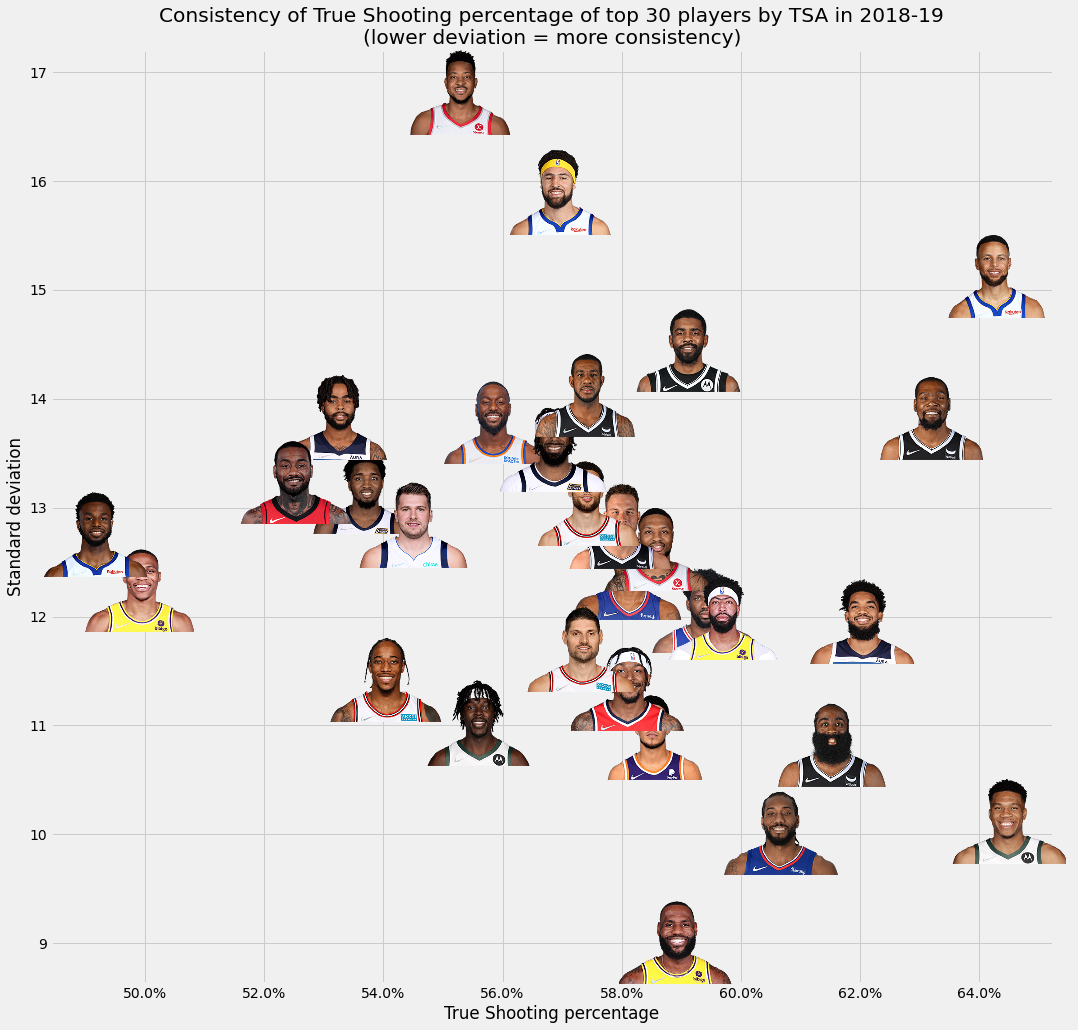

In [20]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of True Shooting percentage of top 30 players by TSA in 2018-19\n(lower deviation = more consistency)")

### 2020-21

In [61]:
season = '2020-21'

In [62]:
game_logs = PlayerGameLogs(season_nullable=season).get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [63]:

variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [64]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2143.05it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2020-21\n(lower deviation = more consistency)')

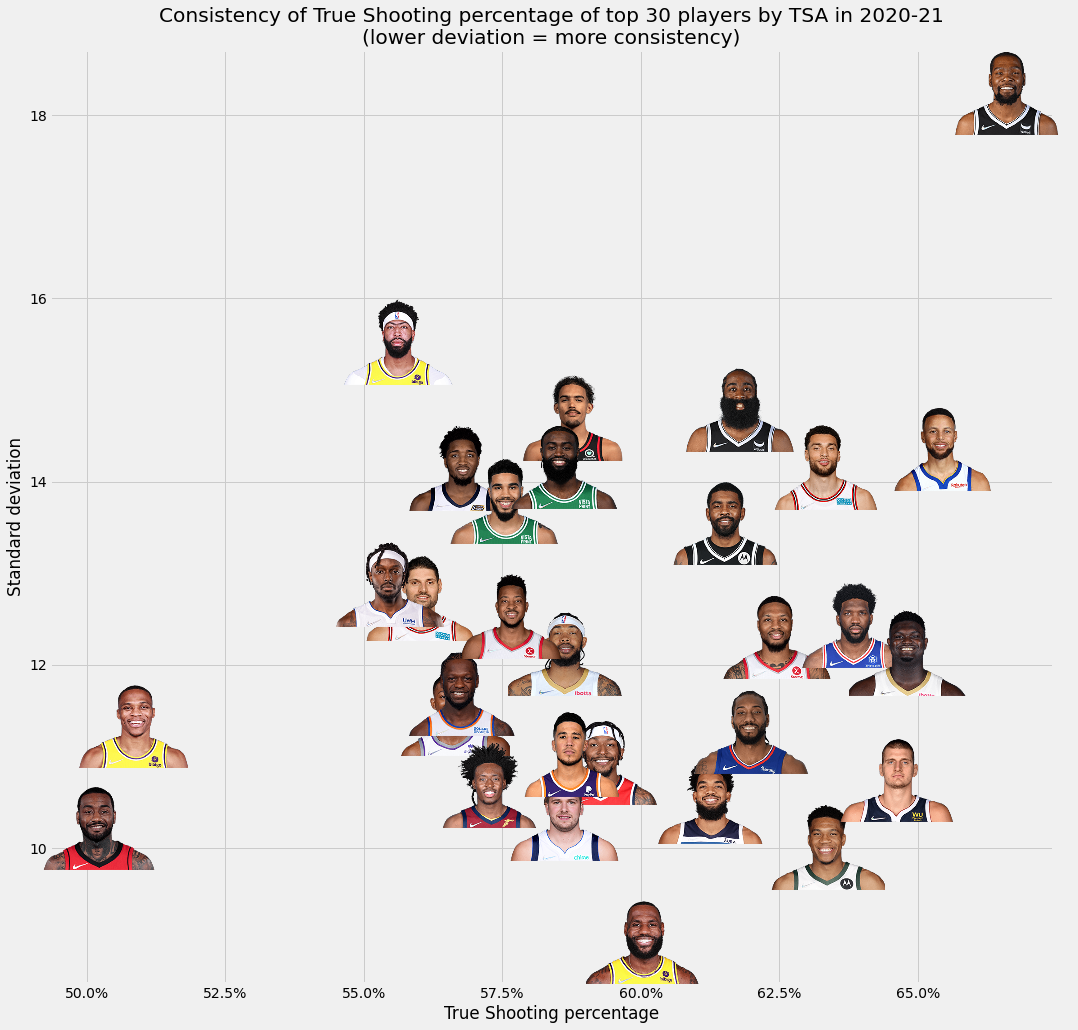

In [65]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title(f"Consistency of True Shooting percentage of top 30 players by TSA in {season}\n(lower deviation = more consistency)")

### 2019-20

In [66]:
season = '2019-20'

game_logs = PlayerGameLogs(season_nullable=season).get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100


variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [67]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2000.30it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2019-20\n(lower deviation = more consistency)')

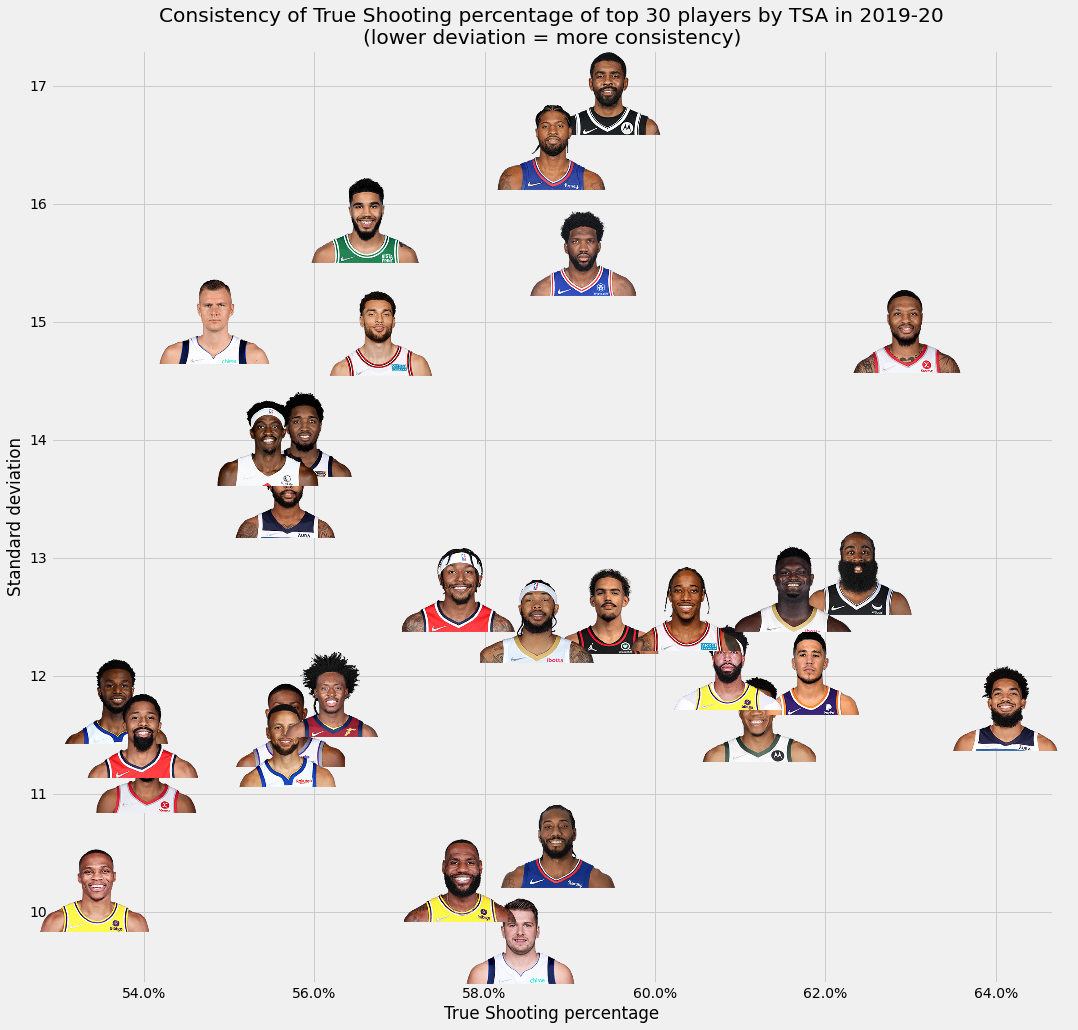

In [68]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title(f"Consistency of True Shooting percentage of top 30 players by TSA in {season}\n(lower deviation = more consistency)")

## Team Variance

In [126]:
season = "2021-22"
team_stats = LeagueDashTeamStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

team_stats.loc[:, 'TSA'] = team_stats.FGA + 0.44 * team_stats.FTA

team_stats.FG3_PCT = team_stats.FG3_PCT * 100

team_stats.loc[:, 'TS_PCT'] = team_stats.PTS / (2 * (team_stats.FGA + 0.44 * team_stats.FTA)) * 100


In [127]:
game_logs = TeamGameLogs(season_nullable=season).get_data_frames()[0]

In [128]:
game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

In [129]:
game_logs.loc[:, 'FG3_PCT'] = game_logs.FG3_PCT * 100

In [130]:

variances = []
ts_variances = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    variances.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].var(ddof=0).FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].var(ddof=0).TS_PCT)

team_stats.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].std(ddof=0).FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].std(ddof=0).TS_PCT)
    
team_stats.loc[:, 'FG3_PCT_DEVIATION'] = deviations

team_stats.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
team_stats.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

Text(0.5, 1.0, 'Consistency of 3pt percentage of teams in 2021-22\n(lower deviation = more consistency)')

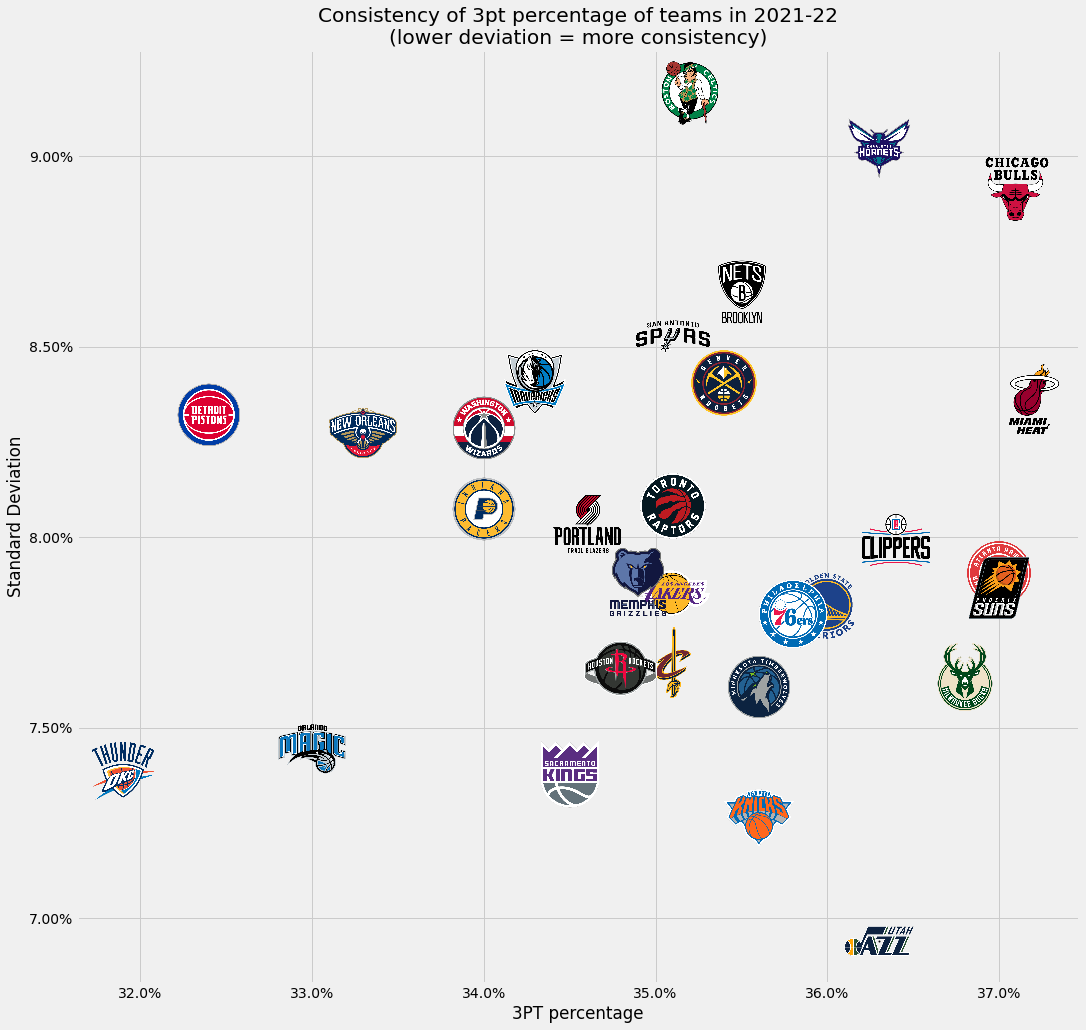

In [131]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=team_stats.FG3_PCT, y=team_stats.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.1), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Standard Deviation")

ax.set_title(f"Consistency of 3pt percentage of teams in {season}\n(lower deviation = more consistency)")

This chart shows the deviation of team's 3pt% percentage through the games this seaosn. Jazz are rock solid and consistent, while the Celtics are most volatile?



Text(0.5, 1.0, 'Consistency of True Shooting Percentage of teams in 2021-22\n(lower variance = more consistency)')

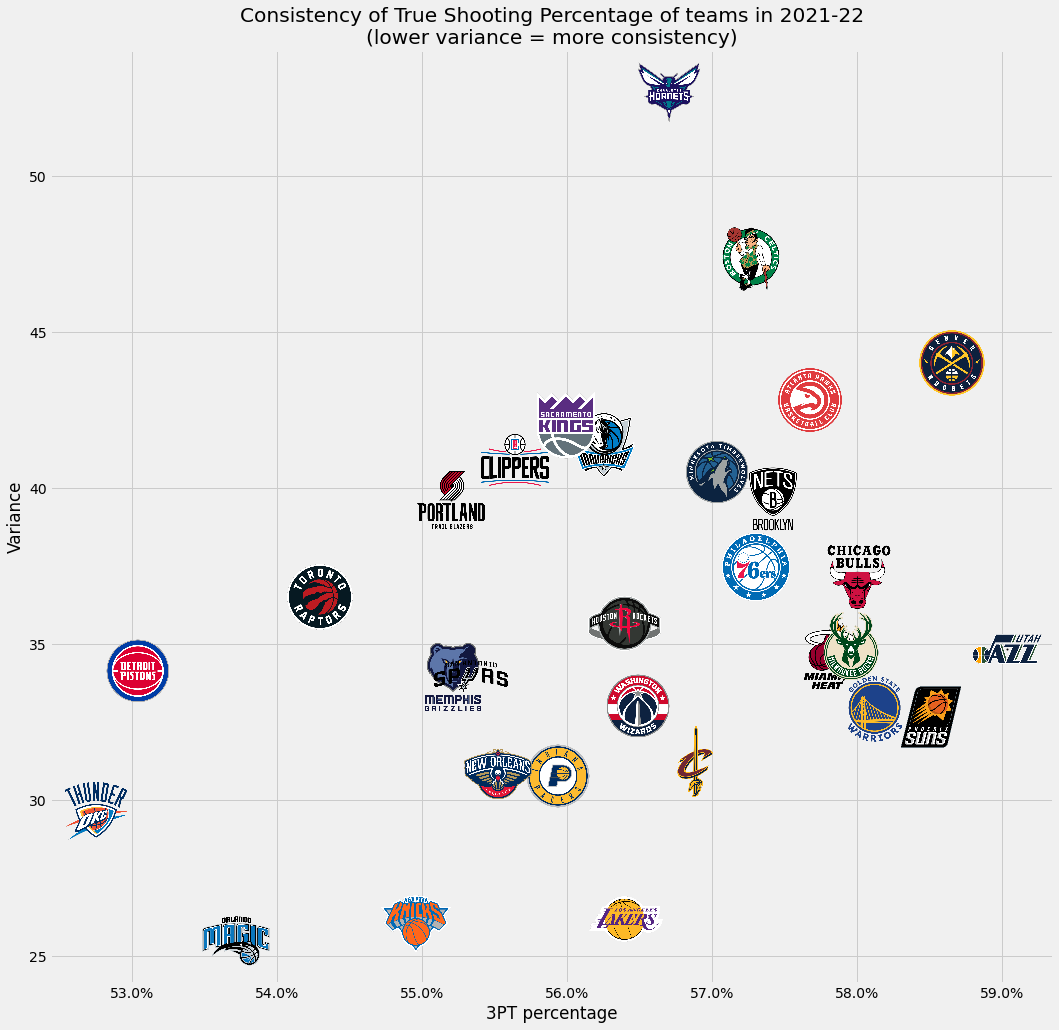

In [47]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=team_stats.TS_PCT, y=team_stats.TS_PCT_VARIANCE, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.1), (item.TS_PCT, item.TS_PCT_VARIANCE), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Variance")

ax.set_title("Consistency of True Shooting Percentage of teams in 2021-22\n(lower variance = more consistency)")

## Wide Open Shots

In [6]:
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder

In [10]:
finder = LeagueGameFinder(league_id_nullable='00', season_type_nullable='Regular Season', season_nullable='2021-22')

In [11]:
schedule_df = finder.get_data_frames()[0]

In [34]:
sorted(schedule_df.GAME_DATE.unique())

['2021-10-19',
 '2021-10-20',
 '2021-10-21',
 '2021-10-22',
 '2021-10-23',
 '2021-10-24',
 '2021-10-25',
 '2021-10-26',
 '2021-10-27',
 '2021-10-28',
 '2021-10-29',
 '2021-10-30',
 '2021-10-31',
 '2021-11-01',
 '2021-11-02',
 '2021-11-03',
 '2021-11-04',
 '2021-11-05',
 '2021-11-06',
 '2021-11-07',
 '2021-11-08',
 '2021-11-09',
 '2021-11-10',
 '2021-11-11',
 '2021-11-12',
 '2021-11-13',
 '2021-11-14',
 '2021-11-15',
 '2021-11-16',
 '2021-11-17',
 '2021-11-18',
 '2021-11-19',
 '2021-11-20',
 '2021-11-21',
 '2021-11-22',
 '2021-11-23',
 '2021-11-24',
 '2021-11-26',
 '2021-11-27',
 '2021-11-28',
 '2021-11-29',
 '2021-11-30',
 '2021-12-01',
 '2021-12-02',
 '2021-12-03',
 '2021-12-04',
 '2021-12-05',
 '2021-12-06',
 '2021-12-07',
 '2021-12-08',
 '2021-12-09',
 '2021-12-10',
 '2021-12-11',
 '2021-12-12',
 '2021-12-13',
 '2021-12-14',
 '2021-12-15',
 '2021-12-16',
 '2021-12-17',
 '2021-12-18',
 '2021-12-19',
 '2021-12-20',
 '2021-12-21',
 '2021-12-22',
 '2021-12-23',
 '2021-12-25',
 '2021-12-

In [23]:
date = '2022-02-08'

In [24]:
format_date = f"{date.split('-')[1]}/{date.split('-')[2]}/{date.split('-')[0]}"

In [25]:
format_date

'02/08/2022'

In [30]:
date

'2022-02-08'

In [31]:
wide_open_df = LeagueDashTeamPtShot(per_mode_simple='PerGame', season='2021-22', close_def_dist_range_nullable='6+ Feet - Wide Open', date_from_nullable=format_date, date_to_nullable=format_date).get_data_frames()[0]

In [35]:
data_frames = []
for cur_date in tqdm.tqdm(sorted(schedule_df.GAME_DATE.unique())):
    wide_open_df = LeagueDashTeamPtShot(per_mode_simple='PerGame', season='2021-22', close_def_dist_range_nullable='6+ Feet - Wide Open', date_from_nullable=cur_date, date_to_nullable=cur_date).get_data_frames()[0]
    data_frames.append(wide_open_df)
    time.sleep(0.5)
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [07:08<00:00,  2.82s/it]


In [36]:
full_wide_open_df = pd.concat(data_frames)

In [46]:
full_wide_open_df.loc[:, 'FG3_PCT'] = full_wide_open_df.FG3_PCT * 100

In [54]:
total_wide_open = LeagueDashTeamPtShot(per_mode_simple='PerGame', season='2021-22', close_def_dist_range_nullable='6+ Feet - Wide Open').get_data_frames()[0]

In [55]:
total_wide_open.loc[:, 'FG3_PCT'] = total_wide_open.FG3_PCT * 100

In [89]:
full_wide_open_df.loc[full_wide_open_df.TEAM_NAME == 'Cleveland Cavaliers']

,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,GP,G,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,1610612739,Cleveland Cavaliers,CLE,1,1,0.386,15.0,34.0,0.441,0.574,0.102,6.0,9.0,0.667,0.284,9.0,25.0,36.0
9,1610612739,Cleveland Cavaliers,CLE,1,1,0.250,9.0,21.0,0.429,0.619,0.024,1.0,2.0,0.500,0.226,8.0,19.0,42.1
6,1610612739,Cleveland Cavaliers,CLE,1,1,0.213,6.0,19.0,0.316,0.474,0.022,0.0,2.0,0.000,0.191,6.0,17.0,35.3
12,1610612739,Cleveland Cavaliers,CLE,1,1,0.207,8.0,17.0,0.471,0.618,0.037,3.0,3.0,1.000,0.171,5.0,14.0,35.7
17,1610612739,Cleveland Cavaliers,CLE,1,1,0.173,5.0,14.0,0.357,0.464,0.025,2.0,2.0,1.000,0.148,3.0,12.0,25.0
0,1610612739,Cleveland Cavaliers,CLE,1,1,0.333,8.0,29.0,0.276,0.397,0.057,1.0,5.0,0.200,0.276,7.0,24.0,29.2
10,1610612739,Cleveland Cavaliers,CLE,1,1,0.253,9.0,23.0,0.391,0.565,0.022,1.0,2.0,0.500,0.231,8.0,21.0,38.1
15,1610612739,Cleveland Cavaliers,CLE,1,1,0.167,6.0,15.0,0.400,0.567,0.022,1.0,2.0,0.500,0.144,5.0,13.0,38.5
14,1610612739,Cleveland Cavaliers,CLE,1,1,0.216,9.0,16.0,0.563,0.781,0.027,2.0,2.0,1.000,0.189,7.0,14.0,50.0
5,1610612739,Cleveland Cavaliers,CLE,1,1,0.293,12.0,24.0,0.500,0.646,0.061,5.0,5.0,1.000,0.232,7.0,19.0,36.8


In [90]:
full_wide_open_df.loc[full_wide_open_df.TEAM_NAME == 'Miami Heat']

,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,GP,G,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
3,1610612748,Miami Heat,MIA,1,1,0.167,8.0,16.0,0.500,0.688,0.031,2.0,3.0,0.667,0.135,6.0,13.0,46.2
14,1610612748,Miami Heat,MIA,1,1,0.154,3.0,14.0,0.214,0.321,0.022,0.0,2.0,0.000,0.132,3.0,12.0,25.0
14,1610612748,Miami Heat,MIA,1,1,0.184,5.0,16.0,0.313,0.438,0.046,1.0,4.0,0.250,0.138,4.0,12.0,33.3
14,1610612748,Miami Heat,MIA,1,1,0.188,8.0,18.0,0.444,0.556,0.063,4.0,6.0,0.667,0.125,4.0,12.0,33.3
4,1610612748,Miami Heat,MIA,1,1,0.242,7.0,22.0,0.318,0.409,0.055,3.0,5.0,0.600,0.187,4.0,17.0,23.5
17,1610612748,Miami Heat,MIA,1,1,0.182,13.0,16.0,0.813,1.094,0.068,4.0,6.0,0.667,0.114,9.0,10.0,90.0
9,1610612748,Miami Heat,MIA,1,1,0.205,6.0,17.0,0.353,0.471,0.072,2.0,6.0,0.333,0.133,4.0,11.0,36.4
6,1610612748,Miami Heat,MIA,1,1,0.210,5.0,17.0,0.294,0.382,0.049,2.0,4.0,0.500,0.160,3.0,13.0,23.1
11,1610612748,Miami Heat,MIA,1,1,0.167,7.0,13.0,0.538,0.615,0.115,5.0,9.0,0.556,0.051,2.0,4.0,50.0
14,1610612748,Miami Heat,MIA,1,1,0.192,9.0,15.0,0.600,0.867,0.026,1.0,2.0,0.500,0.167,8.0,13.0,61.5


In [70]:
team_only_df.FG3_PCT.std(ddof=0)

12.903697592378535

In [62]:
mean = 40.1

In [67]:
var_sum = 0
for item in team_only_df.iterrows():
    var_sum += (item[1].FG3_PCT - mean) ** 2

In [69]:
(var_sum / len(team_only_df)) ** 0.5

12.907697961552506

In [79]:
variances = []
deviations = []

for team_name in total_wide_open.TEAM_NAME.tolist():
    team_only_df = full_wide_open_df.loc[full_wide_open_df.TEAM_NAME == team_name]
    mean = total_wide_open.loc[total_wide_open.TEAM_NAME == team_name].iloc[0].FG3_PCT
    var_sum = 0
    for item in team_only_df.iterrows():
        var_sum += (item[1].FG3_PCT - mean) ** 2
    deviations.append((var_sum / len(team_only_df)) ** 0.5)

In [80]:
total_wide_open.loc[:, 'FG3_PCT_DEVIATION'] = deviations

In [87]:
season = '2021-22'

Text(0.5, 1.0, 'Consistency of WIDE OPEN 3pt percentage of teams in 2021-22\n(lower deviation = more consistency)')

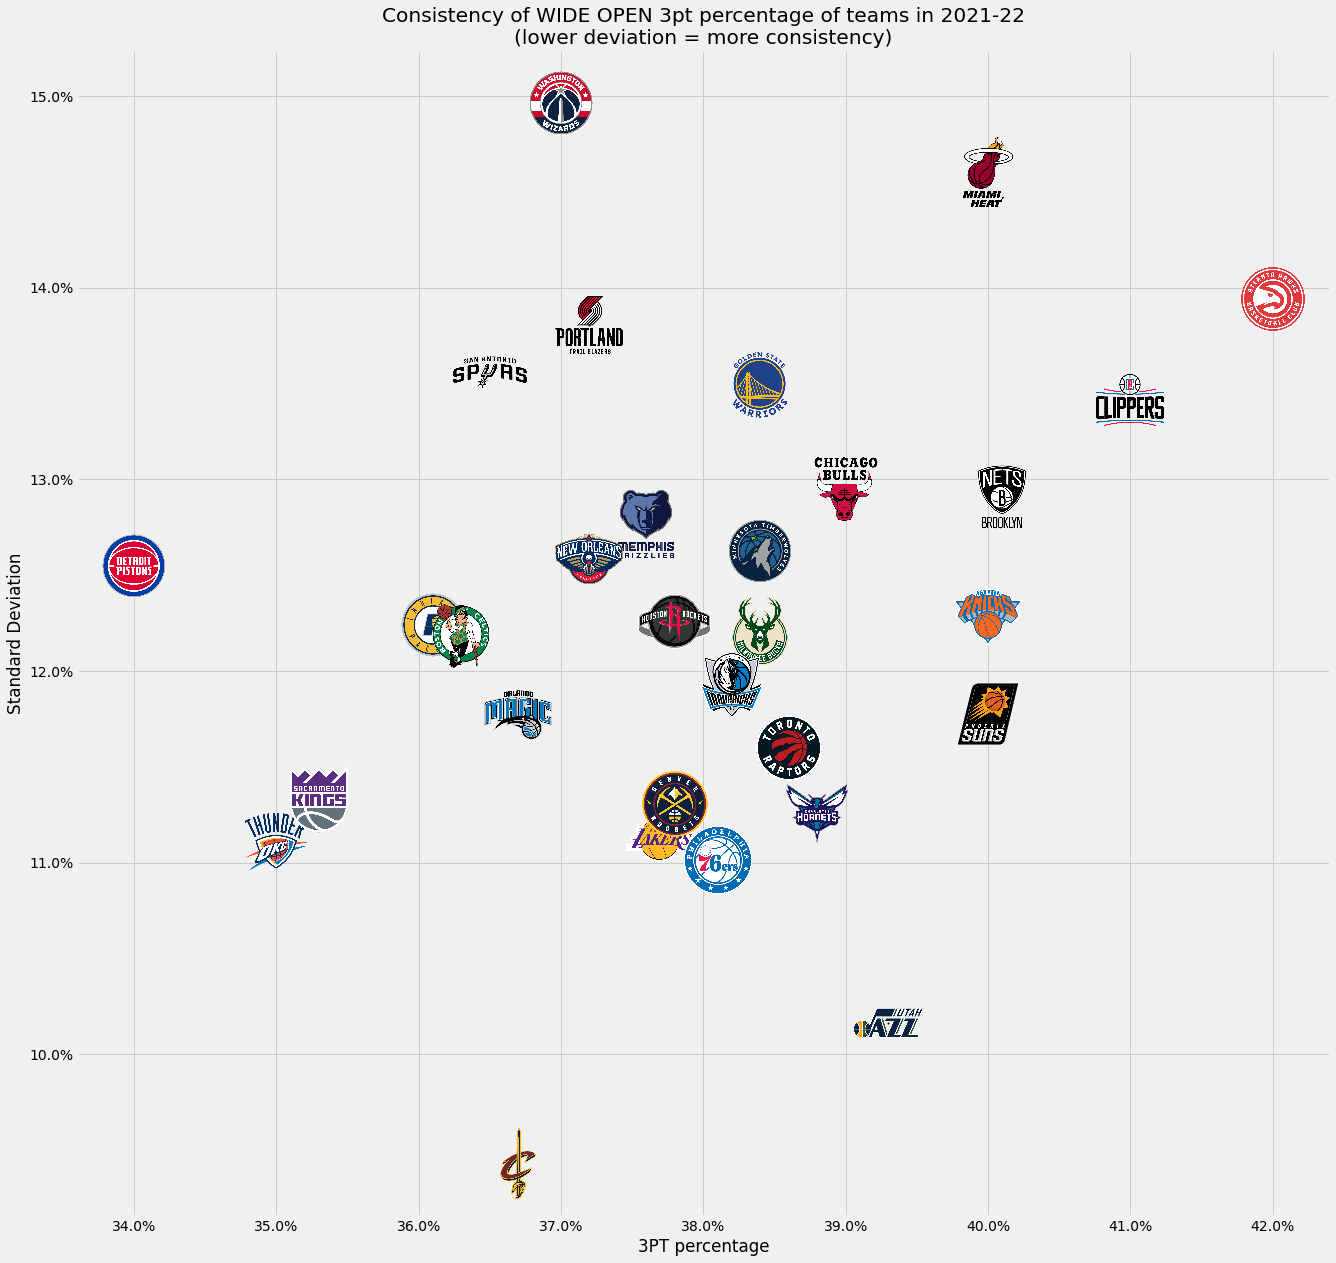

In [88]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=total_wide_open.FG3_PCT, y=total_wide_open.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(total_wide_open)):
    item = total_wide_open.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.1), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Standard Deviation")

ax.set_title(f"Consistency of WIDE OPEN 3pt percentage of teams in {season}\n(lower deviation = more consistency)")

In [97]:
season = "2021-22"
team_stats = LeagueDashTeamStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]
team_stats.FG3_PCT = team_stats.FG3_PCT * 100


In [98]:
game_logs = TeamGameLogs(season_nullable=season).get_data_frames()[0]
game_logs.loc[:, 'FG3_PCT'] = game_logs.FG3_PCT * 100

In [99]:

deviations = []
ts_deviations = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].std(ddof=0).FG3_PCT)
    
team_stats.loc[:, 'FG3_PCT_DEVIATION'] = deviations


In [101]:
merged_df = pd.merge(left=total_wide_open, right=team_stats, on=['TEAM_ID', 'TEAM_NAME'], suffixes=('', '_ALL'))

Text(0.5, 1.0, 'Deviation of All 3pt Shots vs Deviation of Wide Open 3pt Shots 2021-22\n(lower deviation = more consistency)')

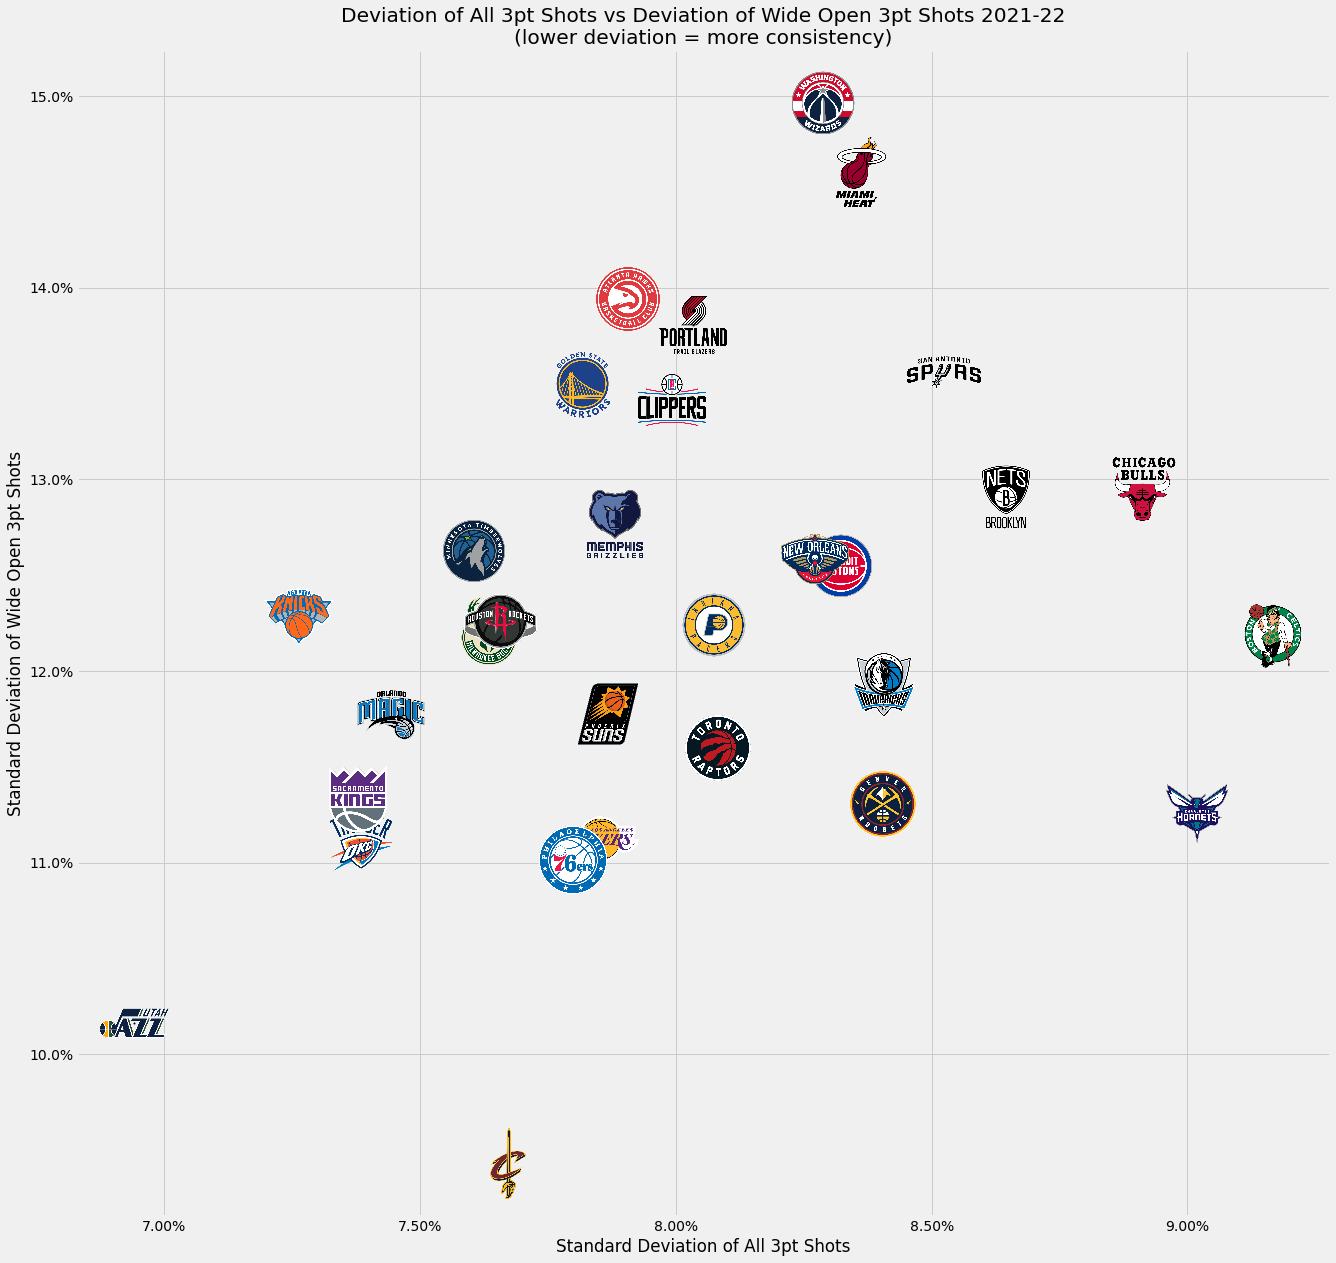

In [107]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=merged_df.FG3_PCT_DEVIATION_ALL, y=merged_df.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(merged_df)):
    item = merged_df.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.1), (item.FG3_PCT_DEVIATION_ALL, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("Standard Deviation of All 3pt Shots")
ax.set_ylabel("Standard Deviation of Wide Open 3pt Shots")


ax.set_title(f"Deviation of All 3pt Shots vs Deviation of Wide Open 3pt Shots {season}\n(lower deviation = more consistency)")